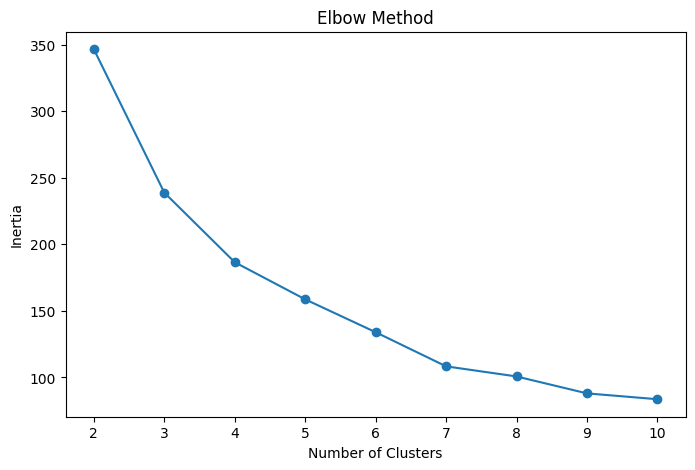

Davies-Bouldin Index: 0.8332101559650619
Silhouette Score: 0.36394726235843006


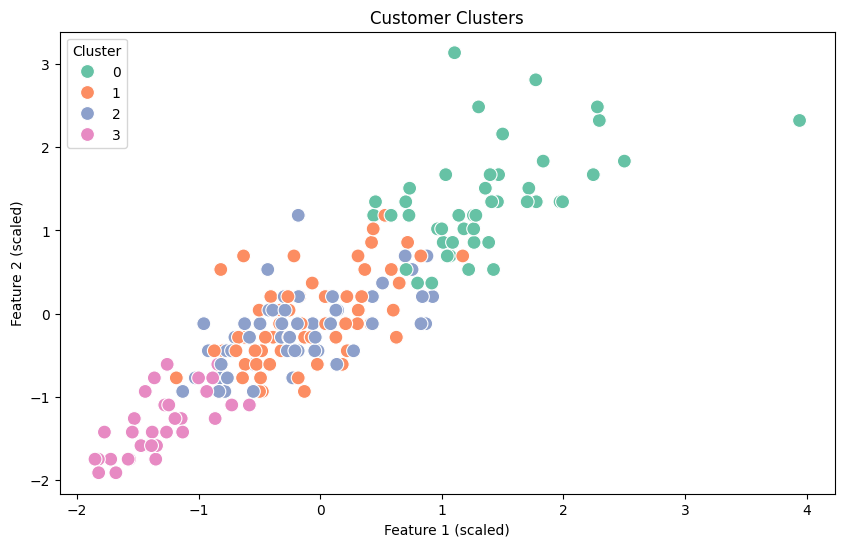

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets and aggregate transaction data
transactions_summary = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total transaction value
    "Quantity": "sum",    # Total quantity purchased
}).reset_index()

# Merge with customer profiles
merged_data = pd.merge(customers, transactions_summary, on="CustomerID", how="inner")

# Feature Engineering
merged_data["SignupDays"] = (pd.Timestamp.now() - pd.to_datetime(merged_data["SignupDate"])).dt.days
features = merged_data[["TotalValue", "Quantity", "SignupDays"]]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow Method to find optimal number of clusters
inertia = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Use KMeans with optimal number of clusters
optimal_k = 4  # Change this based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(features_scaled)
merged_data["Cluster"] = clusters

# Evaluate Clustering
db_index = davies_bouldin_score(features_scaled, clusters)
silhouette_avg = silhouette_score(features_scaled, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features_scaled[:, 0], y=features_scaled[:, 1], hue=clusters, palette="Set2", s=100
)
plt.title("Customer Clusters")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend(title="Cluster")
plt.show()

# Save results
merged_data.to_csv("Customer_Segments.csv", index=False)
